This notebook has some additional analyses. It uses some of the same functions from the first notebook, but loads them from `self_shade.py`.

In [1]:
from self_shade import shade_fractions, non_linear_shade, plant_power_with_shade_losses
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5, style='white')
mpl.rcParams['figure.figsize'] = (12, 8)
print(f'pvlib version: {pvlib.__version__}')

pvlib version: 0.10.4


Load plant specs:

In [2]:
filename = 'plant_specs_pvpmc_rev2.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header).set_index('unit_id') # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants

Because we found in [2024_pvpmc_self_shade.ipynb](2024_pvpmc_self_shade.ipynb) that `isotropic` seemed best, let's switch everything to that model:

In [3]:
plants_df['default_site_transposition_model'] = 'isotropic'

NSRDB API info:

In [4]:
## API key credentials are stored in a separate text file
try:
    with open('credentials/nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        api_key = f.readline().rstrip()
except:
    print('error with email and API key, using temporary defaults')
    print('register at https://developer.nrel.gov/')
    print('create the folder and text file referenced above with email on first line and API key on second line')
    api_key = 'DEMO_KEY'
    email = 'your_email@domain.com'

Here's a range of GCR values from plant 40:

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator
c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator
c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


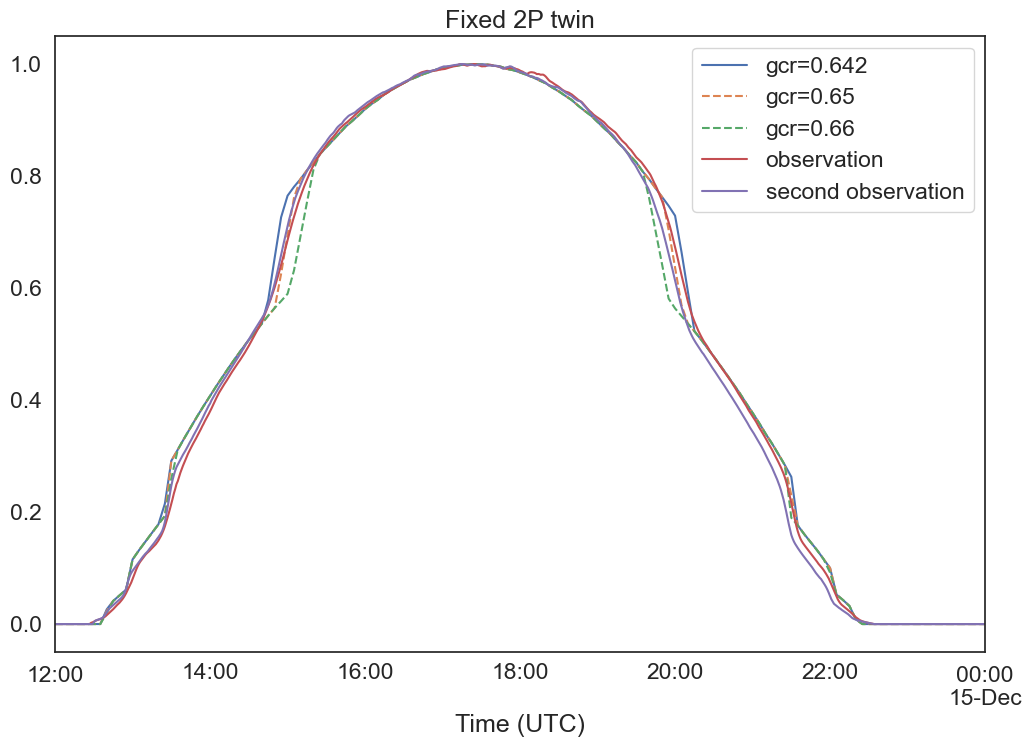

In [5]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates = ["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')

power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates = ["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 attributes=[],
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled, _ = plant_power_with_shade_losses(resource_data, **plant_data)

plant_data_new = { **plant_data,
                  'gcr':0.65,
}
power_ac_modeled_tuned, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

plant_data_new = { **plant_data,
                  'gcr':0.66,
}
power_ac_modeled_tuned2, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]] / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_modeled_tuned.loc[times[0]:times[-1]] / power_ac_modeled_tuned.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_ac_modeled_tuned2.loc[times[0]:times[-1]] / power_ac_modeled_tuned2.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['gcr=0.642', 'gcr=0.65', 'gcr=0.66', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Time (UTC)');

It looks like a GCR of 0.65 is a little better than the value we had of 0.642. This might be because what was actually built was a little different from the drawings, or because the site isn't perfectly flat, or other reasons. 

Let's use the new GCR and look at some detail on inflection points in the morning:

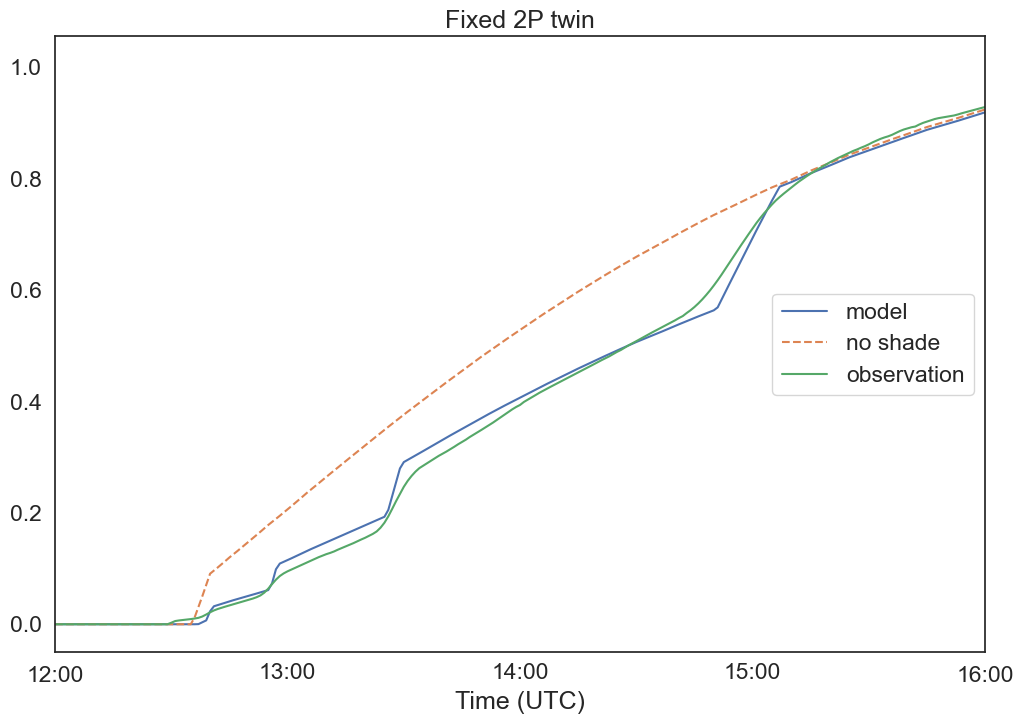

In [6]:
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

plant_data_new = { **plant_data,
                'gcr':0.65,
                }

power_ac_modeled, fs_array = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                'gcr':0.00000001,
                'row_side_num_mods':1,
                'shade_loss_type':'linear',
                'cell_type':'thin-film',
                }
power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)

plt.legend(['model', 'no shade', 'observation'],loc="center right")

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

Now add the shaded fraction calculated for each effective course (4 total, since we have 2P twin modules):

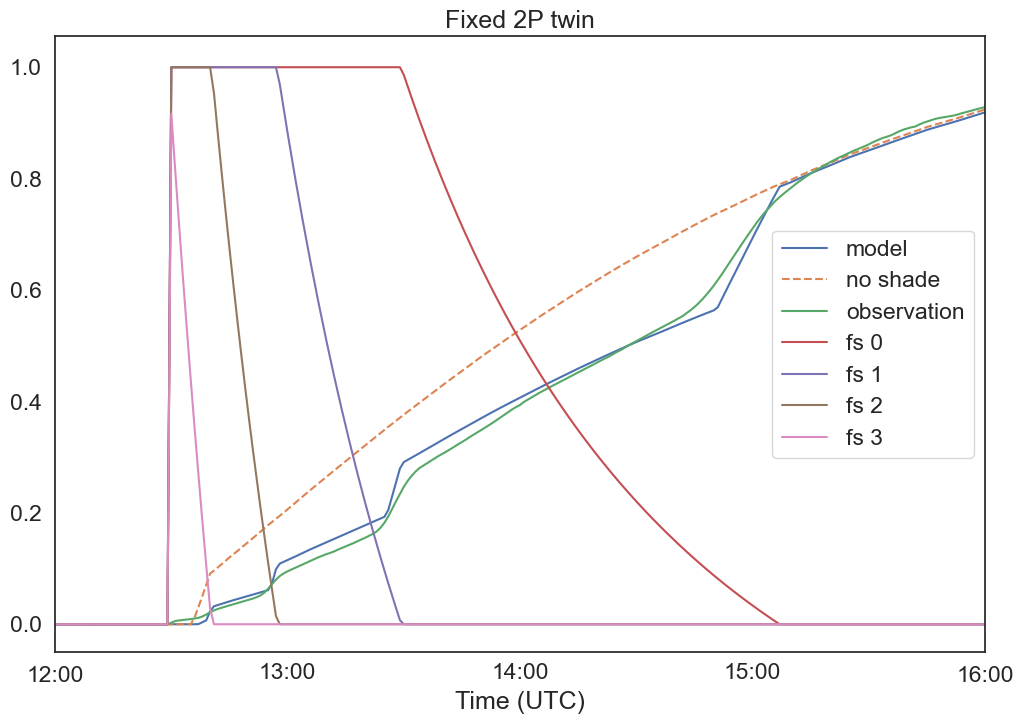

In [7]:
fs = shade_fractions(fs_array, eff_row_side_num_mods=4)
fs_df = pd.DataFrame(data=fs.transpose(),index=fs_array.index)

times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

plant_data_new = { **plant_data,
                'gcr':0.65,
                }

power_ac_modeled, fs_array = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                'gcr':0.00000001,
                'row_side_num_mods':1,
                'shade_loss_type':'linear',
                'cell_type':'thin-film',
                }
power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
fs_df.loc[times[0]:times[-1]].plot(ax=ax)
plt.legend(['model', 'no shade', 'observation', 'fs 0', 'fs 1', 'fs 2', 'fs 3'],loc="center right")

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

And add vertical lines where fs is zero and where is is equal to the width of just one cell:

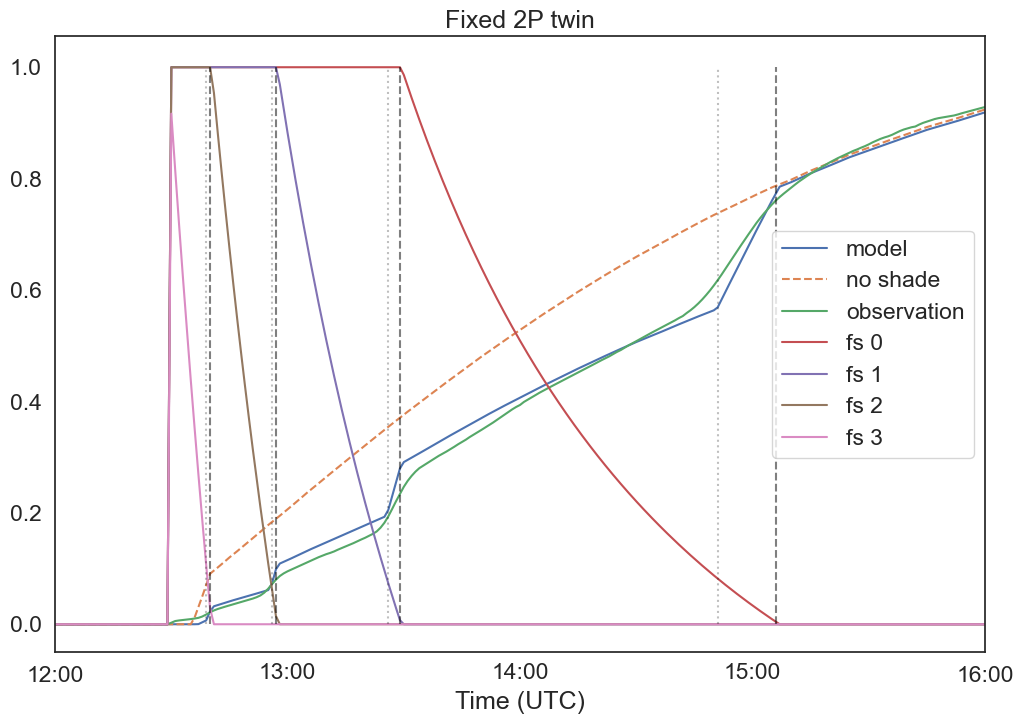

In [8]:
fs = shade_fractions(fs_array, eff_row_side_num_mods=4)
fs_df = pd.DataFrame(data=fs.transpose(),index=fs_array.index)

times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

plant_data_new = { **plant_data,
                'gcr':0.65,
                }

power_ac_modeled, fs_array = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                'gcr':0.00000001,
                'row_side_num_mods':1,
                'shade_loss_type':'linear',
                'cell_type':'thin-film',
                }
power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
fs_df.loc[times[0]:times[-1]].plot(ax=ax)
# plt.legend(['model', 'no shade', 'observation'],loc="center right")
plt.legend(['model', 'no shade', 'observation', 'fs 0', 'fs 1', 'fs 2', 'fs 3'],loc="center right")

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

# add vertical lines at points of interest
# trim shaded fraction to just the morning
fs_array = fs_array.loc[times[0]:times[-1]]

# for 2P system, shadow hits edges of modules/parallel sub-modules at fs_array = 0.75, 0.5, 0.25, and 0
targets = [.75, .5, .25, 0.001]
target_times = [fs_array.iloc[(fs_array-target).abs().argsort()[:1]].index.to_pydatetime() for target in targets]
plt.vlines(target_times, ymin=0, ymax=1, color='black', linestyle='--', alpha=0.5)

# add the shaded fraction "width" of one cell
fs_one_cell = 1/plant_data['n_cells_up']/plant_data['row_side_num_mods']
targets = [.75+fs_one_cell, .5+fs_one_cell, .25+fs_one_cell, fs_one_cell]
target_times = [fs_array.iloc[(fs_array-target).abs().argsort()[:1]].index.to_pydatetime() for target in targets]
plt.vlines(target_times, ymin=0, ymax=1, color='black', linestyle=':', alpha=0.25)

plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

And the same, but with array-level fs:

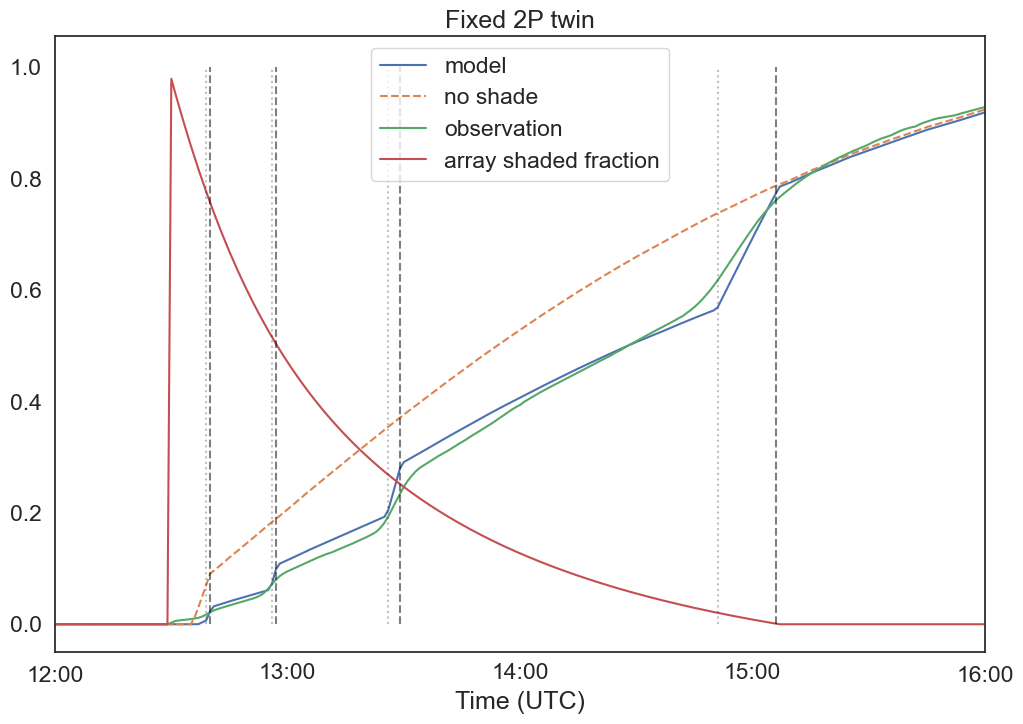

In [9]:
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

plant_data_new = { **plant_data,
                'gcr':0.65,
                }

power_ac_modeled, fs_array = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                'gcr':0.00000001,
                'row_side_num_mods':1,
                'shade_loss_type':'linear',
                'cell_type':'thin-film',
                }
power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
fs_array.loc[times[0]:times[-1]].plot(ax=ax)
plt.legend(['model', 'no shade', 'observation', 'array shaded fraction'])

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

# add vertical lines at points of interest
# trim shaded fraction to just the morning
fs_array = fs_array.loc[times[0]:times[-1]]

# for 2P system, shadow hits edges of modules/parallel sub-modules at fs_array = 0.75, 0.5, 0.25, and 0
targets = [.75, .5, .25, 0.001]
target_times = [fs_array.iloc[(fs_array-target).abs().argsort()[:1]].index.to_pydatetime() for target in targets]
plt.vlines(target_times, ymin=0, ymax=1, color='black', linestyle='--', alpha=0.5)

# add the shaded fraction "width" of one cell
fs_one_cell = 1/plant_data['n_cells_up']/plant_data['row_side_num_mods']
targets = [.75+fs_one_cell, .5+fs_one_cell, .25+fs_one_cell, fs_one_cell]
target_times = [fs_array.iloc[(fs_array-target).abs().argsort()[:1]].index.to_pydatetime() for target in targets]
plt.vlines(target_times, ymin=0, ymax=1, color='black', linestyle=':', alpha=0.25)

plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

And without the vertical lines:

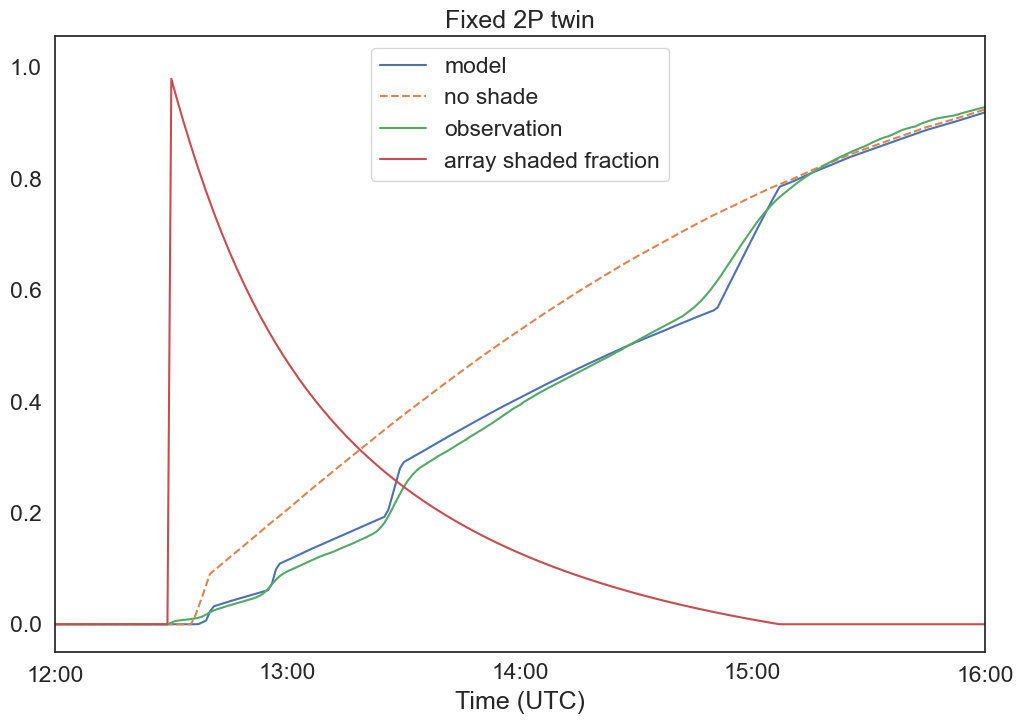

In [10]:
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
resource_data = resource_data.loc[times[0]:times[-1]].resample('1T').interpolate('linear')

plant_data_new = { **plant_data,
                'gcr':0.65,
                }

power_ac_modeled, fs_array = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                'gcr':0.00000001,
                'row_side_num_mods':1,
                'shade_loss_type':'linear',
                'cell_type':'thin-film',
                }
power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
fs_array.loc[times[0]:times[-1]].plot(ax=ax)
plt.legend(['model', 'no shade', 'observation', 'array shaded fraction'])

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

Now let's look at different fractional backtracking strategies. We will use the plant with `unit_id` of 20, but model it as a 2P twin module design. 

In [11]:
unit_id = 20
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

# make some clear sky resource data.
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

# 
plant_data_100 = { **plant_data,
                'row_side_num_mods':2,
                'shade_loss_type':'non-linear_simple_twin_module',
                'cell_type':'cystalline',
                'n_cells_up':26,
                'backtrack_fraction':1,
                'backtrack':True
                }
plant_data_075 = { **plant_data_100,
                'backtrack_fraction':0.75,
                }
plant_data_050 = { **plant_data_100,
                'backtrack_fraction':0.5,
                }
plant_data_025 = { **plant_data_100,
                'backtrack_fraction':0.25,
                }
plant_data_000 = { **plant_data_100,
                'backtrack_fraction':0.0,
                }

power_ac_100, fs_array_100 = plant_power_with_shade_losses(
    resource_data, **plant_data_100)
power_ac_075, fs_array_075 = plant_power_with_shade_losses(
    resource_data, **plant_data_075)
power_ac_050, fs_array_050 = plant_power_with_shade_losses(
    resource_data, **plant_data_050)
power_ac_025, fs_array_025 = plant_power_with_shade_losses(
    resource_data, **plant_data_025)
power_ac_000, fs_array_000 = plant_power_with_shade_losses(
    resource_data, **plant_data_000)


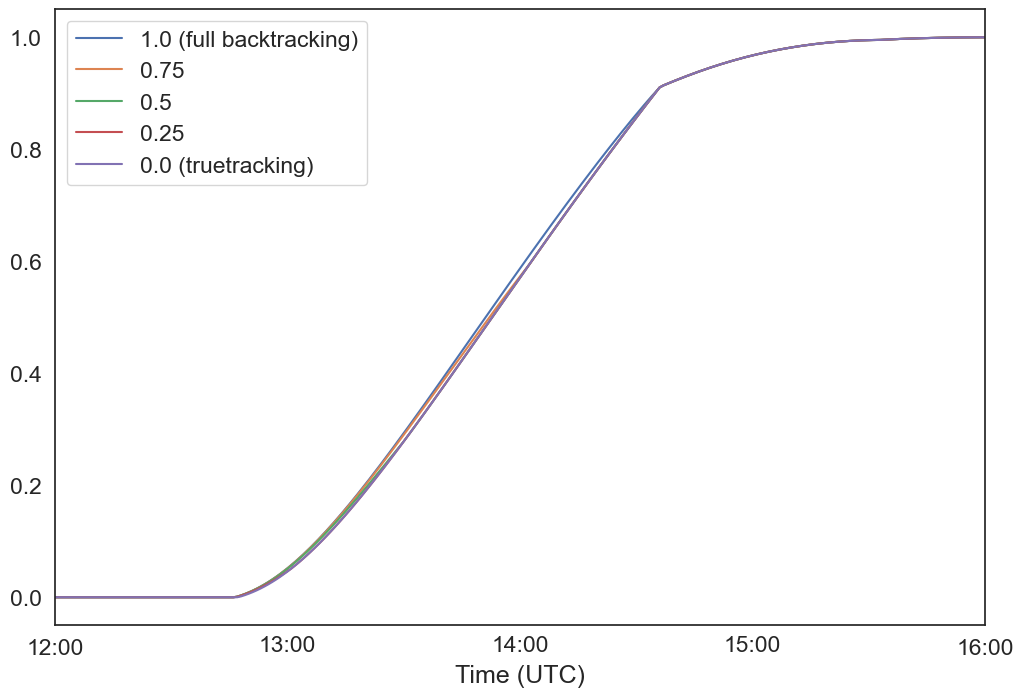

In [12]:
f, ax = plt.subplots(1, 1)
(power_ac_100.loc[times[0]:times[-1]].fillna(0) / power_ac_100.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_075.loc[times[0]:times[-1]].fillna(0) / power_ac_075.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_050.loc[times[0]:times[-1]].fillna(0) / power_ac_050.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_025.loc[times[0]:times[-1]].fillna(0) / power_ac_025.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_000.loc[times[0]:times[-1]].fillna(0) / power_ac_000.loc[times[0]:times[-1]].max()).plot(ax=ax)

plt.legend(['1.0 (full backtracking)','0.75','0.5','0.25','0.0 (truetracking)'])

# trim to just morning time
times = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

# plt.title(plant_data['unit_name'])
plt.xlim([times.min(), times.max()])
plt.xlabel('Time (UTC)');

In [13]:
print(power_ac_100.sum()/12)
print(power_ac_075.sum()/12)
print(power_ac_050.sum()/12)
print(power_ac_025.sum()/12)
print(power_ac_000.sum()/12)

22.089119001769102
22.02277497006757
21.98170579361808
21.963845614427868
21.96187828140388


It looks like conventional backtracking ("full" backtracking) is best. What if we use a full year of NSRDB data?

In [14]:
unit_id = 20
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 attributes=[],
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

# 
plant_data_100 = { **plant_data,
                'row_side_num_mods':2,
                'shade_loss_type':'non-linear_simple_twin_module',
                'cell_type':'cystalline',
                'n_cells_up':26,
                'backtrack_fraction':1,
                'backtrack':True
                }
plant_data_075 = { **plant_data_100,
                'backtrack_fraction':0.75,
                }
plant_data_050 = { **plant_data_100,
                'backtrack_fraction':0.5,
                }
plant_data_025 = { **plant_data_100,
                'backtrack_fraction':0.25,
                }
plant_data_000 = { **plant_data_100,
                'backtrack':False,
                }

power_ac_100, fs_array_100 = plant_power_with_shade_losses(
    resource_data, **plant_data_100)
power_ac_075, fs_array_075 = plant_power_with_shade_losses(
    resource_data, **plant_data_075)
power_ac_050, fs_array_050 = plant_power_with_shade_losses(
    resource_data, **plant_data_050)
power_ac_025, fs_array_025 = plant_power_with_shade_losses(
    resource_data, **plant_data_025)
power_ac_000, fs_array_000 = plant_power_with_shade_losses(
    resource_data, **plant_data_000)


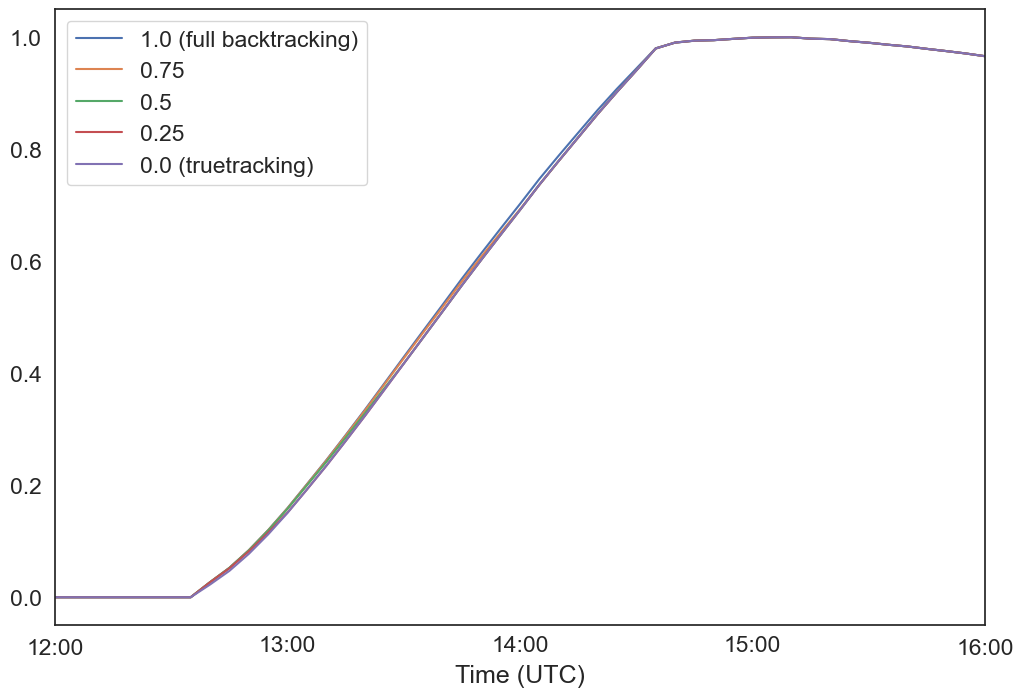

In [15]:
# trim to just morning time
times_plot = pd.date_range('2021-12-14 12:00', '2021-12-14 16:00', freq='1min', tz='UTC')

f, ax = plt.subplots(1, 1)
(power_ac_100.loc[times_plot[0]:times_plot[-1]].fillna(0) / power_ac_100.loc[times_plot[0]:times_plot[-1]].max()).plot(ax=ax)
(power_ac_075.loc[times_plot[0]:times_plot[-1]].fillna(0) / power_ac_075.loc[times_plot[0]:times_plot[-1]].max()).plot(ax=ax)
(power_ac_050.loc[times_plot[0]:times_plot[-1]].fillna(0) / power_ac_050.loc[times_plot[0]:times_plot[-1]].max()).plot(ax=ax)
(power_ac_025.loc[times_plot[0]:times_plot[-1]].fillna(0) / power_ac_025.loc[times_plot[0]:times_plot[-1]].max()).plot(ax=ax)
(power_ac_000.loc[times_plot[0]:times_plot[-1]].fillna(0) / power_ac_000.loc[times_plot[0]:times_plot[-1]].max()).plot(ax=ax)

plt.legend(['1.0 (full backtracking)','0.75','0.5','0.25','0.0 (truetracking)'])

# plt.title(plant_data['unit_name'])
plt.xlim([times_plot.min(), times_plot.max()])
plt.xlabel('Time (UTC)');

In [16]:
print(power_ac_100.sum()/12)
print(power_ac_075.sum()/12)
print(power_ac_050.sum()/12)
print(power_ac_025.sum()/12)
print(power_ac_000.sum()/12)

2057.6557829125363
2050.3975198122903
2046.1156614574604
2043.9616736715243
2043.38544672693


Same thing - conventional backtracking seems better than fractional backtracking or truetracking. 

Here's another interesting application for this modeling workflow: looking at trackers with incorrect (drifted) clock settings. Let's model a generic plant with conventional 72 cell crystalline modules and backtracking. We will pass custom surface tilt and azimuth values to `plant_power_with_shade_losses()`, where we have calculated them with drift added to the tracker control clock.

We will use a 10 minute positive drift for this example (e.g., the trackers think it is 8:10 when it is really 8:00)

In [17]:
drift_minutes = 10

plant_data = {
    'latitude': 32.5,
    'longitude': -84.5,
    'altitude': 200.0,
    'mount_type': 'single-axis',
    'axis_azimuth': 180.0,
    'axis_tilt': 0.0,
    'backtrack': True,
    'max_tracker_angle': 45.0,
    'gcr': 0.4,
    'dc_capacity_plant': 1.25,
    'power_plant_ac_max': 1,
    'cell_type': 'cystalline',
    'bifacial': False,
    'module_orientation': 'portrait',
    'row_side_num_mods': 1,
    'dc_loss_fraction': 0.1,
    'gamma_pdc': -0.004,
    'row_height_center': 1.5,
    'n_cells_up': 12,
    'default_site_transposition_model': 'isotropic',
    'shade_loss_model': 'non-linear_simple',
    'backtrack_fraction': 1
}

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 attributes=[],
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

# resource_data = resource_data[0:1500] # uncomment this to just run the first few days

latitude = plant_data['latitude']
longitude = plant_data['longitude']
axis_tilt = plant_data['axis_tilt']
axis_azimuth = plant_data['axis_azimuth']
backtrack = True
gcr = plant_data['gcr']
gcr_tracker = plant_data['gcr']
max_tracker_angle = plant_data['max_tracker_angle']

## tracker position with drifted clock
##---------------------
times = resource_data.index + pd.Timedelta(minutes=drift_minutes) # add offset
loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
solar_position = loc.get_solarposition(times)

# tracker orientation angles
singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                        apparent_azimuth=solar_position.azimuth,
                        axis_tilt=axis_tilt,
                        axis_azimuth=axis_azimuth,
                        backtrack=backtrack,
                        gcr=gcr_tracker,
                        )
orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                        **singleaxis_kwargs)

# remove offset
orientation.index = orientation.index - pd.Timedelta(minutes=drift_minutes)

surface_tilt_drifted = orientation.surface_tilt.fillna(0)
surface_azimuth_drifted = orientation.surface_azimuth.fillna(0)
tracker_theta_drifted = orientation.tracker_theta.fillna(0)
##---------------------

In [18]:
# working tracker clock
power_ac_working, fs_array_working = plant_power_with_shade_losses(
    resource_data, **plant_data)

# drifted tracker clock
power_ac_drifted, fs_array_drifted = plant_power_with_shade_losses(
    resource_data, **plant_data, surface_tilt_timeseries=surface_tilt_drifted,
    surface_azimuth_timeseries=surface_azimuth_drifted)

In [19]:
## tracker position with correct clock
##---------------------
times = resource_data.index 
loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
solar_position = loc.get_solarposition(times)

# tracker orientation angles
singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                        apparent_azimuth=solar_position.azimuth,
                        axis_tilt=axis_tilt,
                        axis_azimuth=axis_azimuth,
                        backtrack=backtrack,
                        gcr=gcr_tracker,
                        )
orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                        **singleaxis_kwargs)
surface_tilt_working = orientation.surface_tilt.fillna(0)
surface_azimuth_working = orientation.surface_azimuth.fillna(0)
tracker_theta_working = orientation.tracker_theta.fillna(0)

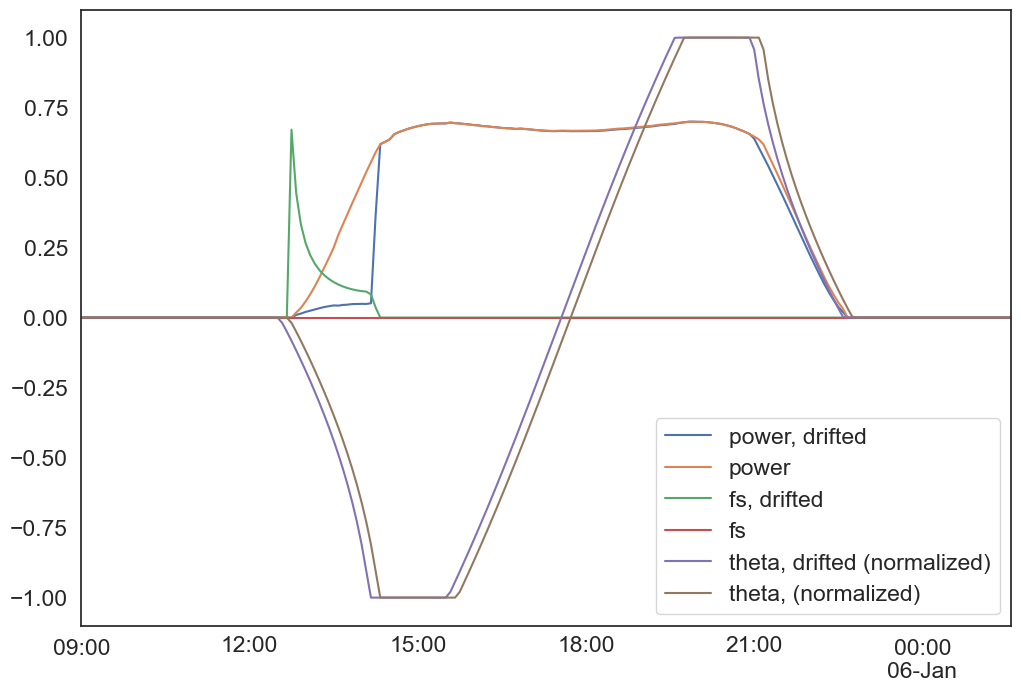

In [20]:
start, stop = 1200, 1400
power_ac_drifted[start:stop].plot(label='power, drifted')
power_ac_working[start:stop].plot(label='power')
fs_array_drifted[start:stop].plot(label='fs, drifted')
fs_array_working[start:stop].plot(label='fs')
(tracker_theta_drifted[start:stop]/tracker_theta_drifted.max()).plot(label='theta, drifted (normalized)')
(tracker_theta_working[start:stop]/tracker_theta_drifted.max()).plot(label='theta, (normalized)')
plt.legend()
plt.show()

In [21]:
(power_ac_drifted.sum()-power_ac_working.sum())/power_ac_working.sum()

-0.045267371060142066

That's a large difference! 

However, there was zero margin for error in backtracking. Some plants use a gcr setting for the tracker controller that is slightly conservative, to help account for non-uniformities. Let's set the `gcr_backtrack_setting` to be 5% higher than actual gcr (I don't know what the typical margin is, but this seems reasonable...) 

In [22]:
plant_data_new = {
    **plant_data,
    'gcr_backtrack_setting' : plant_data['gcr']*1.05
}

gcr_tracker = plant_data_new['gcr_backtrack_setting']

# tracker position with drifted clock
##---------------------
times = resource_data.index + pd.Timedelta(minutes=drift_minutes) # add offset
loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
solar_position = loc.get_solarposition(times)

# tracker orientation angles
singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                        apparent_azimuth=solar_position.azimuth,
                        axis_tilt=axis_tilt,
                        axis_azimuth=axis_azimuth,
                        backtrack=backtrack,
                        gcr=gcr_tracker,
                        )
orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                        **singleaxis_kwargs)

# remove offset
orientation.index = orientation.index - pd.Timedelta(minutes=drift_minutes)

surface_tilt_drifted = orientation.surface_tilt.fillna(0)
surface_azimuth_drifted = orientation.surface_azimuth.fillna(0)
tracker_theta_drifted = orientation.tracker_theta.fillna(0)
##---------------------

# working tracker clock
power_ac_working, fs_array_working = plant_power_with_shade_losses(
    resource_data, **plant_data_new)

# drifted tracker clock
power_ac_drifted, fs_array_drifted = plant_power_with_shade_losses(
    resource_data, **plant_data_new, surface_tilt_timeseries=surface_tilt_drifted,
    surface_azimuth_timeseries=surface_azimuth_drifted)

## tracker position with correct clock
##---------------------
times = resource_data.index 
loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
solar_position = loc.get_solarposition(times)

# tracker orientation angles
singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                        apparent_azimuth=solar_position.azimuth,
                        axis_tilt=axis_tilt,
                        axis_azimuth=axis_azimuth,
                        backtrack=backtrack,
                        gcr=gcr_tracker,
                        )
orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                        **singleaxis_kwargs)
surface_tilt_working = orientation.surface_tilt.fillna(0)
surface_azimuth_working = orientation.surface_azimuth.fillna(0)
tracker_theta_working = orientation.tracker_theta.fillna(0)

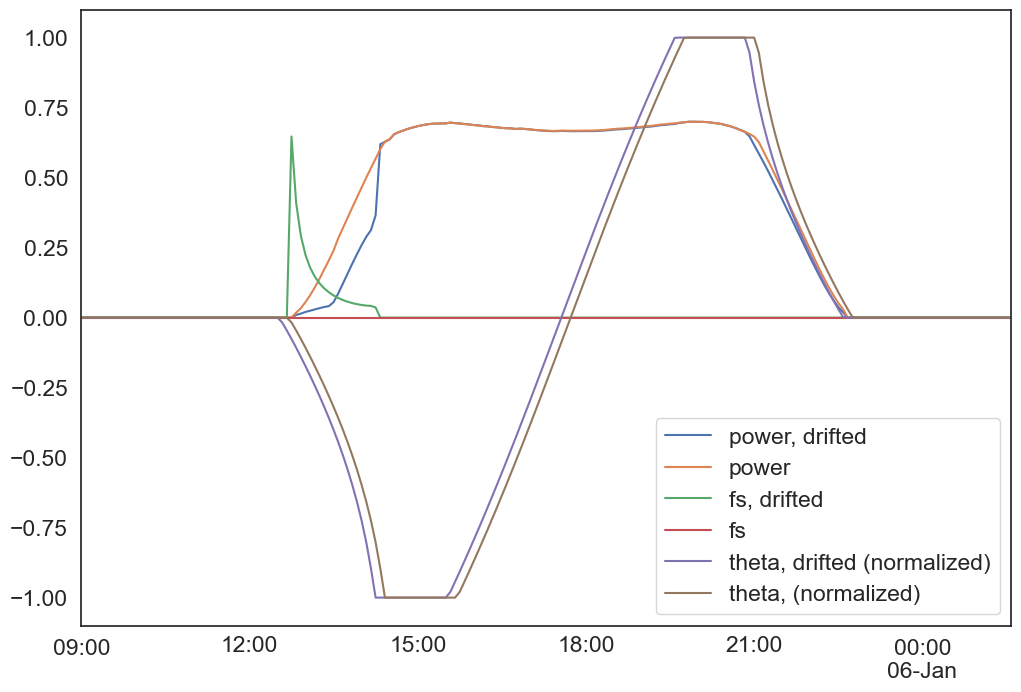

In [23]:
start, stop = 1200, 1400
power_ac_drifted[start:stop].plot(label='power, drifted')
power_ac_working[start:stop].plot(label='power')
fs_array_drifted[start:stop].plot(label='fs, drifted')
fs_array_working[start:stop].plot(label='fs')
(tracker_theta_drifted[start:stop]/tracker_theta_drifted.max()).plot(label='theta, drifted (normalized)')
(tracker_theta_working[start:stop]/tracker_theta_drifted.max()).plot(label='theta, (normalized)')
plt.legend()
plt.show()

In [24]:
(power_ac_drifted.sum()-power_ac_working.sum())/power_ac_working.sum()

-0.0268239800508955

That makes a notable reduction in losses, but it still isn't enough to eliminate the majority of them. 

Now, let's see how much difference accounting for shade can make for the plants we have been modeling.

In [25]:
def find_shade_impact(plant_data):
    # negligible shade w/ linear loss model
    plant_data_new = { **plant_data,
                    'gcr':0.00000001,
                    'row_side_num_mods':1,
                    'shade_loss_type':'linear',
                    'cell_type':'thin-film',
                    }

    resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                    plant_data['longitude'],
                                                    api_key,
                                                    email,
                                                    names='2021',
                                                    interval=5,
                                                    attributes=[],
                                                    map_variables=True,
                                                    leap_day=True,
                                                    )
    # convert to UTC, adjust metadata to match
    resource_data.index = resource_data.index.tz_convert('UTC')
    metadata['Time Zone'] = 0

    power_ac, _ = plant_power_with_shade_losses(resource_data, **plant_data)
    power_ac_no_shade, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)

    difference = (power_ac_no_shade.sum()-power_ac.sum())/power_ac.sum()
    return difference

In [26]:
# pick plant/inv unit number:
unit_id = 10
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

unit_id = 20
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

unit_id = 30
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

unit_id = 40
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

unit_id = 50
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

unit_id = 60
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
difference = find_shade_impact(plant_data)
print(difference)

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


0.02301259326754571
0.08460460532891147


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


0.026980822726099578


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


0.025051756886428356


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


0.01925022958708169


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


0.019041930894430372


Let's take an existing plant and make it bifacial:

In [27]:
unit_id = 40
plant_data = plants_df.loc[unit_id].dropna().to_dict() 
resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                plant_data['longitude'],
                                                api_key,
                                                email,
                                                names='2021',
                                                interval=5,
                                                attributes=[],
                                                map_variables=True,
                                                leap_day=True,
                                                )
power_ac, _ = plant_power_with_shade_losses(resource_data, **plant_data)
print('monofacial sum: ' + str(power_ac.sum()))
plant_data_new = { **plant_data,
                'bifacial':True,
                }
power_ac_bifacial, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)
print('bifacial sum: ' + str(power_ac_bifacial.sum()))
print('relative difference: '+ str((power_ac_bifacial.sum()-power_ac.sum())/power_ac.sum()))

c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


monofacial sum: 24154.27001006904


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator


bifacial sum: 24921.32388640565
relative difference: 0.03175645035088423


And then try bifacial but with bifaciality set to zero, just to make sure it's the same as monofacial from before:

In [28]:
plant_data_new = { **plant_data,
                'bifacial':True,
                'bifaciality':0.0,
                }
power_ac_bifacial, _ = plant_power_with_shade_losses(resource_data, **plant_data_new)
print(power_ac_bifacial.sum())

24154.27001006904


c:\Users\willh\miniforge3\envs\pvlib_env\lib\site-packages\pvlib\temperature.py:1089: RuntimeWarning: invalid value encountered in true_divide
  smoothed = numerator / denominator
